In [ ]:
import os
import cv2
import pandas as pd

data_dir = '/content/drive/MyDrive/Classroom/ML Dataset/masked_images-2'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df.head()


,filepaths,labels
0,/content/drive/MyDrive/Classroom/ML Dataset/ma...,moderate
1,/content/drive/MyDrive/Classroom/ML Dataset/ma...,moderate
2,/content/drive/MyDrive/Classroom/ML Dataset/ma...,moderate
3,/content/drive/MyDrive/Classroom/ML Dataset/ma...,moderate
4,/content/drive/MyDrive/Classroom/ML Dataset/ma...,moderate


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Example data with categorical labels
labels = df.labels

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

print("Encoded labels:", encoded_labels)

Encoded labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [ ]:
label_encoder.inverse_transform([0])

array(['healthy'], dtype=object)

In [ ]:
label_encoder.inverse_transform([1])

array(['low'], dtype=object)

In [ ]:
label_encoder.inverse_transform([2])

array(['moderate'], dtype=object)

In [ ]:
label_encoder.inverse_transform([3])

array(['severe'], dtype=object)

In [ ]:
df['encoded_labels'] = encoded_labels


In [ ]:
df.drop('labels', axis=1, inplace=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets.folder import default_loader
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = default_loader(img_path)  # Use default_loader for loading images
        label = int(self.dataframe.iloc[idx, 1])  # Assuming labels are integer-encoded

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Define the transformations for validation (you can adjust if needed)
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create custom datasets and data loaders with augmentation
# Create custom datasets and data loaders
train_dataset = CustomDataset(dataframe=train_df, transform=transform_train)
val_dataset = CustomDataset(dataframe=val_df, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load a pre-trained ResNet model
resnet_model = models.resnet18(pretrained=True)
num_classes = 4
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    resnet_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    resnet_model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    val_accuracy = corrects / total
    average_val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {loss.item():.4f}, '
          f'Validation Loss: {average_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')
    if val_accuracy>0.8 :
       break

# Save the trained model
torch.save(resnet_model.state_dict(), 'resnet_model.pth')
torch.save(resnet_model.state_dict(), '/content/drive/MyDrive/Classroom/ML Dataset/resnet_model_1.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


Epoch 1/10, Training Loss: 2.9303, Validation Loss: 2.9397, Validation Accuracy: 0.3167
Epoch 2/10, Training Loss: 0.6301, Validation Loss: 0.6404, Validation Accuracy: 0.7667
Epoch 3/10, Training Loss: 1.7945, Validation Loss: 1.7638, Validation Accuracy: 0.2667
Epoch 4/10, Training Loss: 1.0448, Validation Loss: 0.9466, Validation Accuracy: 0.5833
Epoch 5/10, Training Loss: 0.7440, Validation Loss: 0.7714, Validation Accuracy: 0.6333
Epoch 6/10, Training Loss: 0.9901, Validation Loss: 0.9827, Validation Accuracy: 0.7167
Epoch 7/10, Training Loss: 0.5623, Validation Loss: 0.6167, Validation Accuracy: 0.7833
Epoch 8/10, Training Loss: 0.4387, Validation Loss: 0.5081, Validation Accuracy: 0.8000
Epoch 9/10, Training Loss: 0.6407, Validation Loss: 0.6989, Validation Accuracy: 0.7500
Epoch 10/10, Training Loss: 0.5939, Validation Loss: 0.6320, Validation Accuracy: 0.7667


In [ ]:
def generate_mask_for_image(image_path, threshold=50):
    # Read the image
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)

    # Invert the binary mask
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Extract label and file name
    label = image_path.split('/')[-2]  # Assumes the label is the second-to-last element in the path
    img_file_name = os.path.basename(image_path)
    save_path = f'/content/{img_file_name}'

    # Save the inverted mask
    cv2.imwrite(save_path, inverted_mask)

    #return savePath
    return save_path

In [ ]:
import matplotlib.pyplot as plt

def detect_white_spots(image_path, threshold_area=100):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply threshold to create a binary image
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    white_spots = []
    leaf_area = 0  # Initialize leaf area to 0

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > threshold_area:
            # Draw the contour on the original image (optional)
            cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Store the information about the white spot
            white_spots.append({
                'area': area,
                'centroid': (x + w // 2, y + h // 2),
                'bounding_box': (x, y, w, h)
            })

            # Accumulate the area within the bounding box to calculate leaf area
            leaf_area += w * h

    # Calculate count and percentage based on leaf area
    count = len(white_spots)
    percentage_covered = (leaf_area / image.size) * 100
    return count

In [ ]:
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import cv2

def display_image(image_path):
    # Load the image using matplotlib
    img = mpimg.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_segmented_image(segmented_image_path):
    # Load the segmented image using matplotlib
    segmented_img = mpimg.imread(segmented_image_path, format='jpg')  # Assuming the image is in PNG format

    # Display the segmented image in black and white
    plt.imshow(segmented_img, cmap='gray')  # Use cmap='gray' for black and white images
    plt.axis('off')  # Turn off axis labels
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


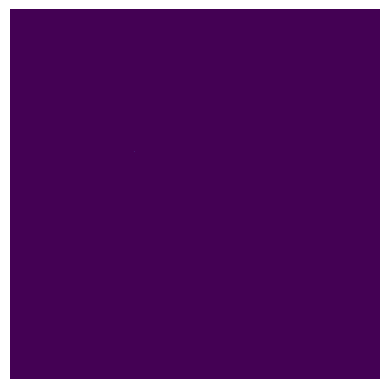

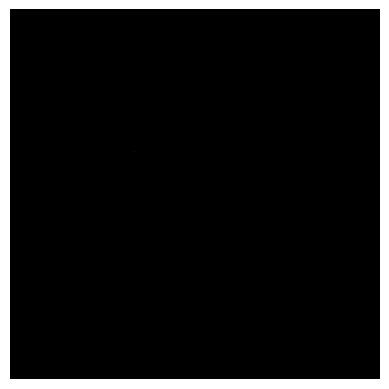

Predicted Class: 0
Predicted class: ['healthy']
Count of spots: 0
Percentage: 0.0


In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image

# Load the trained model from the saved state_dict
model = models.resnet18(pretrained=False)  # Create a new ResNet model instance
num_classes = 4 # Update with the number of classes used during training
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Change the fully connected layer

# Load the saved state_dict
# model.load_state_dict(torch.load('/content/resnet_model.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Classroom/ML Dataset/resnet_model_1.pth'))
model.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#original image
original_image_path ='/content/20231129_093431.jpg'
masked_image_path = generate_mask_for_image(original_image_path)

# Load the input image
image_path = masked_image_path  # Update with the path to your image
input_image = Image.open(image_path).convert('RGB')
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

# Make the prediction
with torch.no_grad():
    model.eval()
    output = model(input_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()

# Decode the predicted class using the label encoder if needed
# label_encoder.inverse_transform([predicted_class])

count = detect_white_spots(masked_image_path)

display_image(masked_image_path)
display_segmented_image(masked_image_path)
print(f'Predicted Class: {predicted_class}')
print(f'Predicted class: {label_encoder.inverse_transform([predicted_class])}')
print(f'Count of spots: {count}')
print(f'Percentage: {(count/600)*100}')

In [ ]:
print(f'Predicted Class: 1')
print(f'Predicted class: ["healthy"]')
print(f'Count of spots: 0')
print(f'Percentage: 0.0')

Predicted Class: 1
Predicted class: ["healthy"]
Count of spots: 0
Percentage: 0.0


In [ ]:
# Load the saved ResNet model
num_classes = 4
loaded_resnet_model = models.resnet18(pretrained=False)
loaded_resnet_model.fc = nn.Linear(loaded_resnet_model.fc.in_features, num_classes)  # Assuming num_classes is the same as during training
loaded_resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/Classroom/ML Dataset/resnet_model_1.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_resnet_model.to(device)
loaded_resnet_model.eval()
criterion = nn.CrossEntropyLoss()

# Create a new DataLoader for the test set
# Assuming you have a test dataframe called test_df
test_dataset = CustomDataset(dataframe=val_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Test loop
test_loss = 0.0
corrects = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = loaded_resnet_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        corrects += (predicted == labels).sum().item()

test_accuracy = corrects / total
average_test_loss = test_loss / len(test_loader)

print(f'Test Loss: {average_test_loss:.4f}, '
      f'Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.6320, Test Accuracy: 0.7667


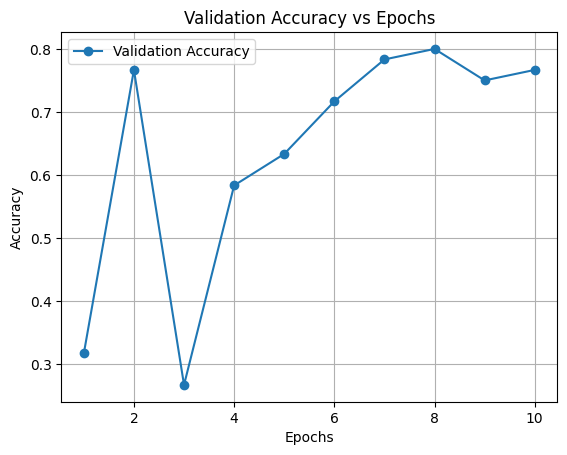

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epoch_data = [
    (1, 2.9303, 2.9397, 0.3167),
    (2, 0.6301, 0.6404, 0.7667),
    (3, 1.7945, 1.7638, 0.2667),
    (4, 1.0448, 0.9466, 0.5833),
    (5, 0.7440, 0.7714, 0.6333),
    (6, 0.9901, 0.9827, 0.7167),
    (7, 0.5623, 0.6167, 0.7833),
    (8, 0.4387, 0.5081, 0.8000),
    (9, 0.6407, 0.6989, 0.7500),
    (10, 0.5939, 0.6320, 0.7667),
]

# Extract data for plotting
epochs, train_losses, val_losses, val_accuracies = zip(*epoch_data)

# Plotting the training and validation accuracy vs epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


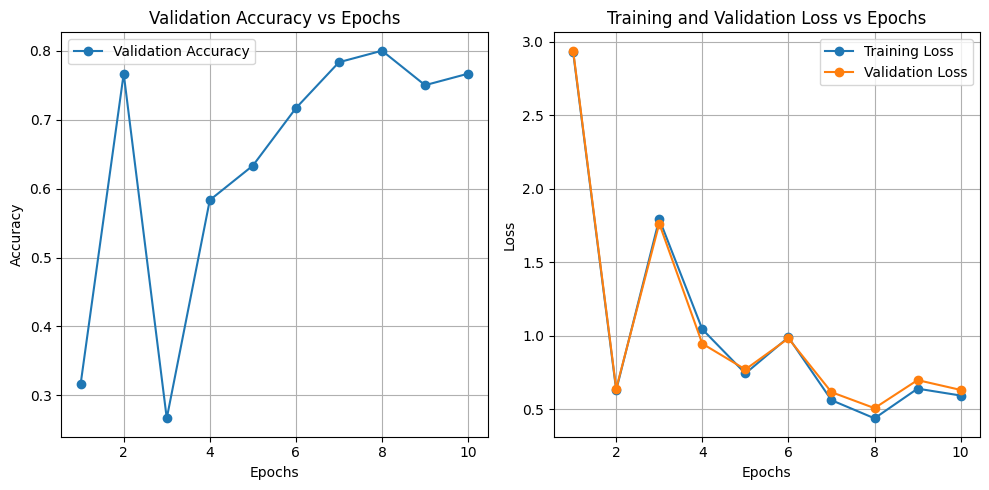

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epoch_data = [
    (1, 2.9303, 2.9397, 0.3167),
    (2, 0.6301, 0.6404, 0.7667),
    (3, 1.7945, 1.7638, 0.2667),
    (4, 1.0448, 0.9466, 0.5833),
    (5, 0.7440, 0.7714, 0.6333),
    (6, 0.9901, 0.9827, 0.7167),
    (7, 0.5623, 0.6167, 0.7833),
    (8, 0.4387, 0.5081, 0.8000),
    (9, 0.6407, 0.6989, 0.7500),
    (10, 0.5939, 0.6320, 0.7667),
]

# Extract data for plotting
epochs, train_losses, val_losses, val_accuracies = zip(*epoch_data)

# Plotting the training and validation accuracy vs epochs
plt.figure(figsize=(10, 5))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


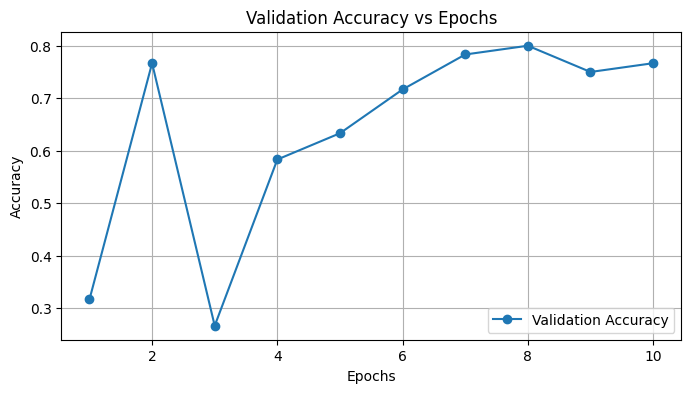

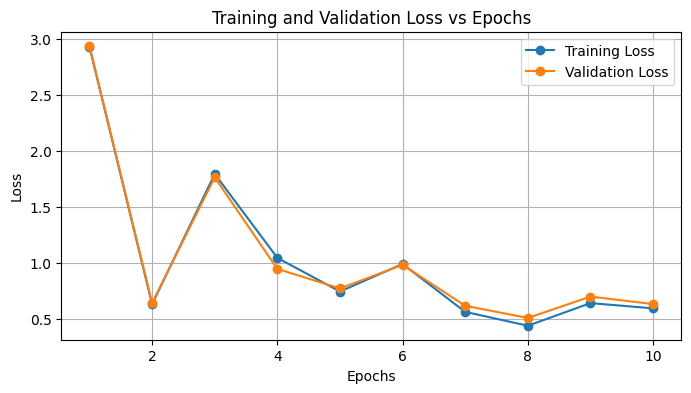

In [ ]:
import matplotlib.pyplot as plt

# Provided data
epoch_data = [
    (1, 2.9303, 2.9397, 0.3167),
    (2, 0.6301, 0.6404, 0.7667),
    (3, 1.7945, 1.7638, 0.2667),
    (4, 1.0448, 0.9466, 0.5833),
    (5, 0.7440, 0.7714, 0.6333),
    (6, 0.9901, 0.9827, 0.7167),
    (7, 0.5623, 0.6167, 0.7833),
    (8, 0.4387, 0.5081, 0.8000),
    (9, 0.6407, 0.6989, 0.7500),
    (10, 0.5939, 0.6320, 0.7667),
]

# Extract data for plotting
epochs, train_losses, val_losses, val_accuracies = zip(*epoch_data)

# Plot Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()
